In [226]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings



In [227]:
warnings.filterwarnings("ignore")
colspecs = [(2, 10), (10, 22), (56, 69), (82, 95)]
names = ['Data', 'Codigo', 'Preco_Abertura', 'Preco_Fechamento']

df_2022 = pd.read_fwf('COTAHIST_A2022.TXT', colspecs=colspecs, names=names, header=None)
df_2023 = pd.read_fwf('COTAHIST_A2023.TXT', colspecs=colspecs, names=names, header=None)
df_2024 = pd.read_fwf('COTAHIST_A2024.TXT', colspecs=colspecs, names=names, header=None)


In [228]:
frames = [df_2022, df_2023]
df_2022e2023 = pd.concat(frames)

In [229]:
AMAZON_df = df_2022e2023[df_2022e2023['Codigo'].str.endswith('AMZO34')].copy()


In [230]:
AMAZON_df['Data'] = pd.to_datetime(AMAZON_df['Data'])
AMAZON_df.set_index('Data', inplace=True)
AMAZON_df.sort_index(inplace=True)

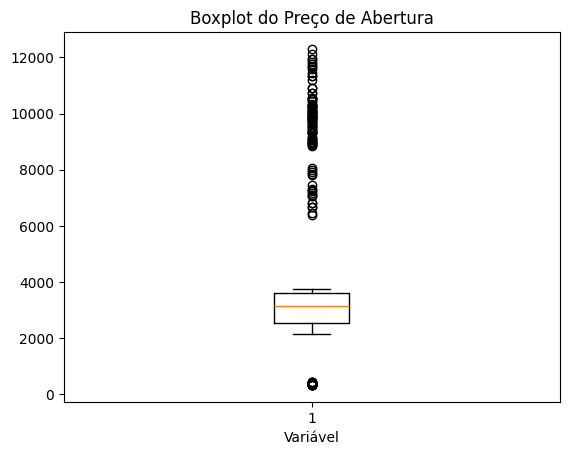

In [231]:

plt.boxplot(AMAZON_df['Preco_Abertura'])
plt.title('Boxplot do Preço de Abertura')
plt.xlabel('Variável')
plt.show()

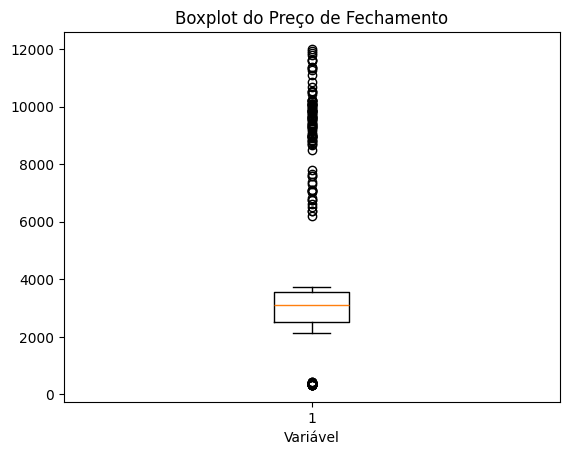

In [232]:

plt.boxplot(AMAZON_df['Preco_Fechamento'])
plt.title('Boxplot do Preço de Fechamento')
plt.xlabel('Variável')
plt.show()

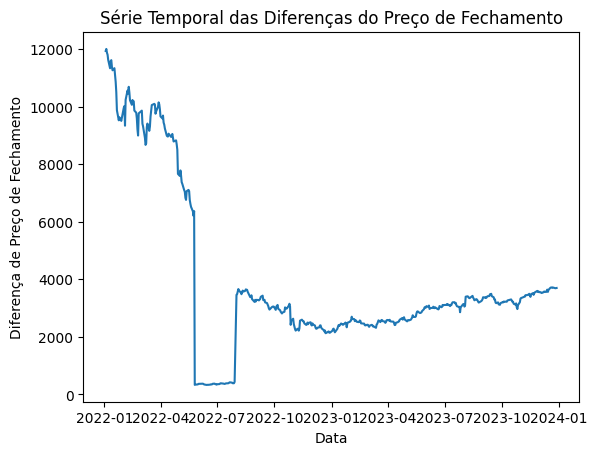

In [233]:
AMAZON_df['Diferenca'] = AMAZON_df['Preco_Fechamento']
plt.plot(AMAZON_df['Diferenca'])
plt.title('Série Temporal das Diferenças do Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Diferença de Preço de Fechamento')
plt.show()

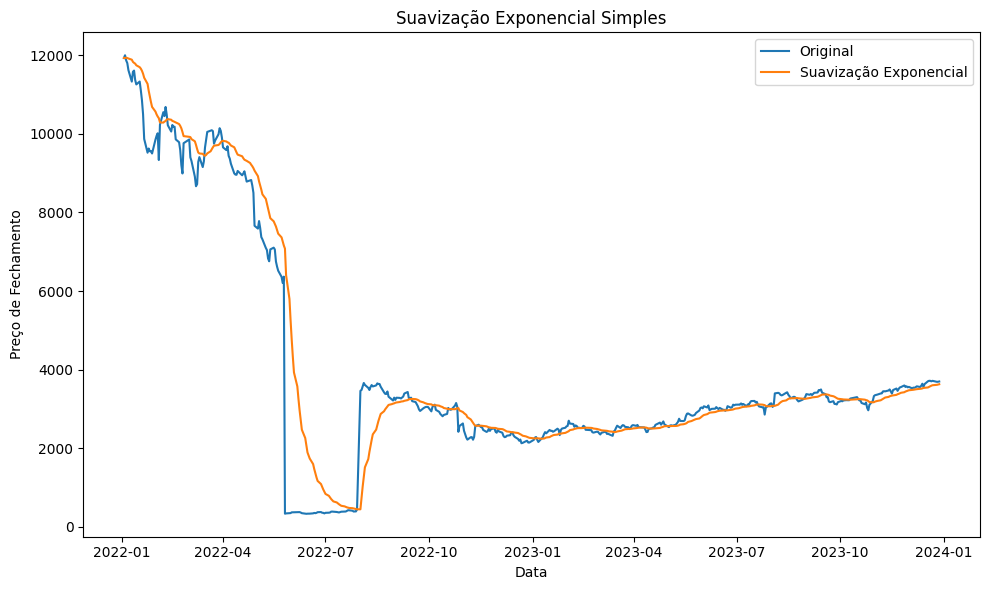

In [234]:
# Exemplo de suavização exponencial simples
alpha = 0.1  # Fator de suavização
model_exp = SimpleExpSmoothing(AMAZON_df['Preco_Fechamento']).fit(smoothing_level=alpha)
AMAZON_df['Suavizacao_EXP'] = model_exp.fittedvalues

# Plotando a suavização exponencial simples
plt.figure(figsize=(10, 6))
plt.plot(AMAZON_df.index, AMAZON_df['Preco_Fechamento'], label='Original')
plt.plot(AMAZON_df.index, AMAZON_df['Suavizacao_EXP'], label='Suavização Exponencial')
plt.title('Suavização Exponencial Simples')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.tight_layout()
plt.show()

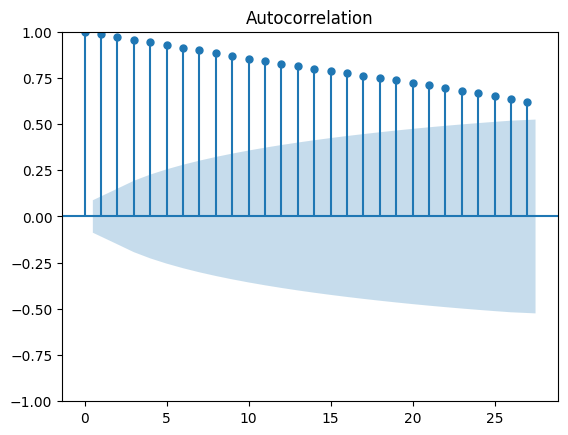

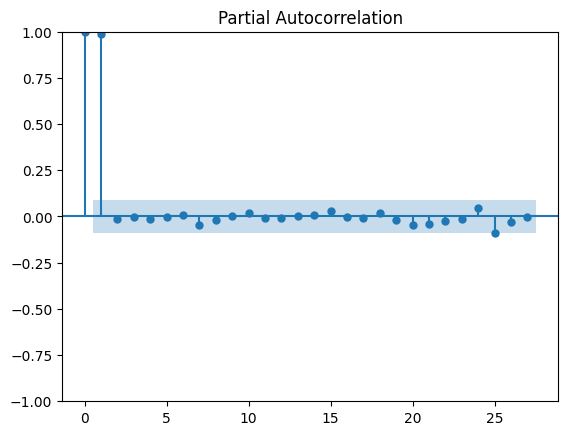

In [235]:
plot_acf(AMAZON_df['Preco_Fechamento'])
plot_pacf(AMAZON_df['Preco_Fechamento'])
plt.show()


In [236]:
resultado_teste = adfuller(AMAZON_df['Preco_Fechamento'])
print('Estatística do teste:', resultado_teste[0])
print('Valor-p:', resultado_teste[1])


Estatística do teste: -2.796826251983487
Valor-p: 0.058728547442937255


In [237]:
p, d, q = 1, 1, 1
modelo = ARIMA(AMAZON_df['Preco_Fechamento'], order=(p, d, q))
resultado = modelo.fit()


In [238]:
horizonte = 10
ultima_data = AMAZON_df.index[-1]
previsoes = resultado.predict(start=len(AMAZON_df), end=len(AMAZON_df)+horizonte-1, typ='levels')

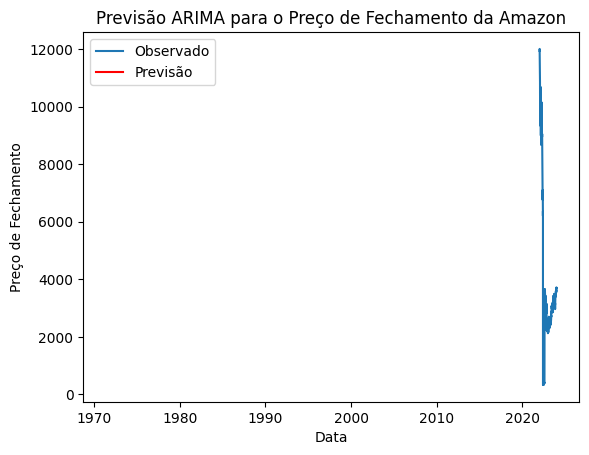

In [239]:
plt.plot(AMAZON_df.index, AMAZON_df['Preco_Fechamento'], label='Observado')
plt.plot(previsoes.index, previsoes, color='red', label='Previsão')
plt.title('Previsão ARIMA para o Preço de Fechamento da Amazon')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()